## Dataset preparation

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.models.segmentation as models
import torch.optim as optim
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.models.segmentation as models
import os
from PIL import Image
from sklearn.metrics import average_precision_score

In [ ]:
IMAGE_DIR = "/kaggle/input/mrose-data/split data/train images"
MASK_DIR = "/kaggle/input/mrose-data/split data/train masks"

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load Image
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = Image.fromarray(image)  # Convert to PIL Image
        
        # Load Mask
        mask_path = os.path.join(self.masks_dir, self.image_filenames[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        mask = cv2.resize(mask, (160, 160), interpolation=cv2.INTER_NEAREST)
        mask = torch.tensor(mask / 255.0, dtype=torch.float)  # Normalize mask to (0,1)
        # mask shape -> (160, 160)

        if self.transform:
            image = self.transform(image)  # Apply transformations
        
        return image, mask

# Define Transformations for Images
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
# Create Dataset and DataLoader
dataset = SegmentationDataset(IMAGE_DIR, MASK_DIR, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## Model training

In [ ]:
# Load Pre-trained DeepLabV3 Model
model = models.deeplabv3_resnet50(pretrained=True)
num_classes = 1  # Binary segmentation (1 output channel)
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
model.to(device)

# Define Loss and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 30
epoch_loss = []
batch_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch = 1
    batch_loss = []
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).unsqueeze(1)  # Add channel dim
        
        # images shape -> (16,3,160,160)
        # masks shape -> (16,1,160,160)

        optimizer.zero_grad()
        outputs = model(images)["out"]
        
        # outputs shape -> (16,1,160,160)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()  # Update weights
        
        # batch_loss.append(loss.item())
        running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Batch {batch}, Loss: {loss.item()}")
        batch+=1
    
    # batch_losses.append(batch_loss)
    epoch_loss.append(running_loss/len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

print("Training Complete!")

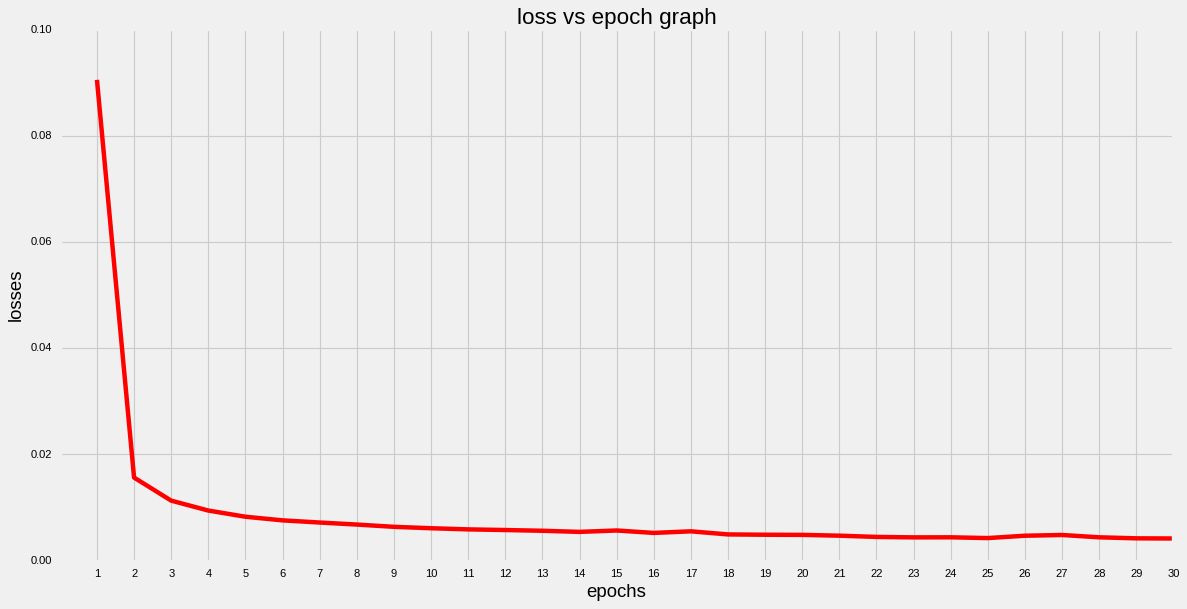

In [51]:
plt.figure(figsize=(16,8))
plt.plot(list(range(1,31)), epoch_loss, color='red')
plt.xticks(range(1,31))
plt.xlabel("epochs")
plt.ylabel("losses")
plt.title("loss vs epoch graph")
plt.style.use('fivethirtyeight')
plt.savefig("/kaggle/working/loss_vs_epoch_graph.png", bbox_inches='tight', dpi=300)

In [43]:
styles = plt.style.available
styles

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
# torch.save(model, "/kaggle/working/seg_model.pth")
# torch.save(epoch_loss, "/kaggle/working/epoch_loss.pth")

In [6]:
model = torch.load("/kaggle/working/seg_model.pth")
epoch_loss = torch.load("/kaggle/working/epoch_loss.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<ipython-input-6-a27780d99f51>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/working/seg_model.pth")
<ipython-input-6-a27780d99f51>:2: FutureW

## Model Evaluation

In [52]:
def calculate_accuracy(outputs, masks):
    preds = torch.sigmoid(outputs) > 0.5
    correct = torch.sum(preds == masks)
    total = masks.numel()
    # print(f"correct: {correct}, total: {total}")
    return correct.float() / total

def calculate_iou(outputs, masks):
    preds = torch.sigmoid(outputs) > 0.5
    masks = masks.int()
    preds = preds.int()
    intersection = torch.sum(preds & masks)
    union = torch.sum(preds | masks)
    # print(intersection, union)
    return intersection.float() / union.float()

def calculate_map(outputs, masks):
    preds = torch.sigmoid(outputs)
    outputs_flat = preds.view(-1).cpu().detach().numpy()
    masks_flat = masks.view(-1).cpu().detach().numpy()
    masks_flat = (masks_flat > 0.5).astype(int)
    return average_precision_score(masks_flat, outputs_flat)

In [53]:
TEST_IMAGE_DIR = "/kaggle/input/mrose-data/split data/test images"
TEST_MASK_DIR = "/kaggle/input/mrose-data/split data/test masks"

# Test Dataset
test_dataset = SegmentationDataset(TEST_IMAGE_DIR, TEST_MASK_DIR, transform=transform)  # No transformation for test
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [55]:
# Set model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize variables to track metrics
total_accuracy = 0.0
total_iou = 0.0
total_map = 0.0
total_samples = 0

# Evaluate the model on the test dataset
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device).unsqueeze(1)  # Add channel dim

        # Forward pass through the model
        outputs = model(images)["out"]

        # Calculate accuracy, IoU, and mAP for this batch
        batch_accuracy = calculate_accuracy(outputs, masks)
        batch_iou = calculate_iou(outputs, masks)
        batch_map = calculate_map(outputs, masks)

        total_accuracy += batch_accuracy.item()
        total_iou += batch_iou.item()
        total_map += batch_map

        total_samples += 1

In [56]:
# Calculate average metrics over all batches
avg_accuracy = total_accuracy / total_samples
avg_iou = total_iou / total_samples
avg_map = total_map / total_samples

# Print the evaluation results
print(f"Test Accuracy: {avg_accuracy:.4f}")
print(f"Test IoU: {avg_iou:.4f}")
print(f"Test mAP: {avg_map:.4f}")

print("Evaluation metric successfully performed!")

Test Accuracy: 0.9961
Test IoU: 0.6033
Test mAP: 0.8713
Evaluation metric succeefully performed!


## Visualize output masks

In [57]:
for img, mask in test_loader:
    input_image = img.to(device)
    ground_truth_mask = mask.to(device)
    break
input_image.shape, ground_truth_mask.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 160, 160]))

In [58]:
model.eval() # it ensures that 'BatchNorm' and 'DropOut' layers behave properly for inference.
with torch.no_grad(): # Reduces memory consumption (by not storing computation graphs) and Speeds up inference.
    output = model(input_image)["out"]
    
preds = torch.sigmoid(output)
predicted_masks = (preds > 0.5).int() # here, 'preds' is 'tensor' datatype

In [60]:
image_np = input_image[index].cpu().permute(1, 2, 0).numpy()
mask_np = ground_truth_mask[index].cpu().squeeze().numpy()
pred_np = predicted_masks[index].cpu().squeeze().numpy()

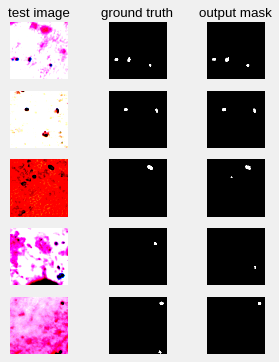

In [77]:
position = 1

fig = plt.figure(figsize=(4,5))

for index in range(5):
    image_np = input_image[index].cpu().permute(1, 2, 0).numpy()
    mask_np = ground_truth_mask[index].cpu().squeeze().numpy()
    pred_np = predicted_masks[index].cpu().squeeze().numpy()
    
    

    plt.subplot(5,3,position)
    plt.imshow(image_np)
    if (index==0):
        plt.title("test image", fontsize=12)
    plt.axis("off")
    
    
    plt.subplot(5,3,position+1)
    plt.imshow(mask_np, "gray")
    if (index==0):
        plt.title("ground truth", fontsize=12)
    plt.axis("off")

   
    plt.subplot(5,3,position+2)
    plt.imshow(pred_np, "gray")
    if (index==0):
        plt.title("output mask", fontsize=12)
    plt.axis("off")

    position = position+3
    
plt.savefig("/kaggle/working/segmentation_result12.png", bbox_inches="tight", dpi=300)
plt.show()